In [1]:

from sklearn.feature_extraction.text import CountVectorizer
from src.utils.path_utils import get_project_root
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pathlib import Path
import seaborn as sns
import pandas as pd
import numpy as np
import string
import nltk
import os
import re

DATA_FOLDER = os.path.join(get_project_root(), 'artifacts')

## 1. Data Ingestion ##

In [12]:
from src.config.configuration import ConfigurationManager

config = ConfigurationManager(notebook_artifacts = True) #all the artificate generated from notebook are stored in seperate notebook folder only
jupiter_notebook_config = config.get_notebook_data_config()

jupiter_notebook_config

[2023-08-26 15:40:07,744: INFO: common: yaml file: F:\github_workspace\stackoverflow_tag_question\config\config.yaml loaded successfully]
[2023-08-26 15:40:07,747: INFO: common: yaml file: F:\github_workspace\stackoverflow_tag_question\params.yaml loaded successfully]
JupiterNotebookConfig(artifacts_dir='artifacts', root_dir='notebook', data_filename='SO_Tag_prediction.parquet', cleaned_data_filename='tags_text_processed.parquet')


In [2]:
from src.entity.data_ingestion import DataIngestion

data_ingestion_config = config.get_data_ingestion_config()
data_ingestion_obj = DataIngestion(Config = data_ingestion_config)

In [4]:
data_ingestion_obj.unzip_db()

[2023-08-26 15:27:12,601: INFO: data_ingestion: [unzip_db]: Unzip datafile: [F:\github_workspace\stackoverflow_tag_question\artifacts\notebook\stackoverflow-moderation.zip]...]
[2023-08-26 15:27:12,603: INFO: data_ingestion: [unzip_db]: Unzip data file does not exists...]
[2023-08-26 15:27:12,604: INFO: data_ingestion: [unzip_db]: Unzip data file at [F:\github_workspace\stackoverflow_tag_question\artifacts\notebook]...]
[2023-08-26 15:27:13,618: INFO: data_ingestion: [unzip_db]: Extacted sucessfully...]


In [5]:
output_path = data_ingestion_obj.combine_train_test_dbset()
output_path

[2023-08-26 15:27:23,901: INFO: data_ingestion: [combine_train_test_dbset]: Merge train and test files...]
[2023-08-26 15:27:28,301: INFO: data_ingestion: [combine_train_test_dbset]: Combine filename at [F:\github_workspace\stackoverflow_tag_question\artifacts\notebook\SO_Tag_prediction.parquet]...]


WindowsPath('F:/github_workspace/stackoverflow_tag_question/artifacts/notebook/SO_Tag_prediction.parquet')

## 2. Exploratory Data Analysis and Cleaning ##

In [6]:
input_filepath = output_path
#input_filepath = Path(DATA_FOLDER).joinpath(jupiter_notebook_config.artifacts_dir).joinpath(jupiter_notebook_config.root_dir).joinpath(jupiter_notebook_config.data_filename)

In [9]:
df = pd.read_parquet(input_filepath, engine = 'fastparquet')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103140 entries, 23636 to 43779
Data columns (total 15 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   PostId                               103140 non-null  int64  
 1   PostCreationDate                     103140 non-null  object 
 2   OwnerUserId                          103140 non-null  int64  
 3   OwnerCreationDate                    103140 non-null  object 
 4   ReputationAtPostCreation             103140 non-null  int64  
 5   OwnerUndeletedAnswerCountAtPostTime  103140 non-null  int64  
 6   Title                                103140 non-null  object 
 7   BodyMarkdown                         103140 non-null  object 
 8   Tag1                                 103132 non-null  object 
 9   Tag2                                 81493 non-null   object 
 10  Tag3                                 53910 non-null   object 
 11  Tag4      

In [3]:
df.head()

,PostId,PostCreationDate,OwnerUserId,OwnerCreationDate,ReputationAtPostCreation,OwnerUndeletedAnswerCountAtPostTime,Title,BodyMarkdown,Tag1,Tag2,Tag3,Tag4,Tag5,PostClosedDate,OpenStatus
index,,,,,,,,,,,,,,,
23636,38262,01/01/2009 00:16:11,3264,08/27/2008 02:45:05,12469,218,good book recomendation for c++0x?,good book recomendation for c++0x?,c++0x,books,None,None,None,NaN,not constructive
62857,102155,01/01/2009 08:44:51,50588,12/31/2008 12:22:50,39,3,Who doesn't trust a language whose sytax doesn...,A GENERAL question to programmers about how th...,ruby,semicolon,terminate,None,None,NaN,not constructive
38940,63094,01/01/2009 10:42:15,41972,11/29/2008 23:15:56,195,8,"Do you prefer ""if (var)"" or ""if (var != 0)""",I've been programming in C-derived languages f...,c,perl,discussion,coding-style,None,NaN,not constructive
23696,38357,01/01/2009 11:23:33,25204,10/04/2008 10:27:22,599,47,Missing/desired features in Notepad++,If the free source code editor [Notepad++][1] ...,notepad++,scite,features,hidden-features,subjective,NaN,not constructive
48626,78893,01/01/2009 11:56:58,32799,10/30/2008 08:54:51,242,6,Is this a Windows XP firewall bug?,I have a webserver running on my Windows XP co...,windows-xp,firewall,bug,None,None,NaN,off topic


**Observation:**

* For this problem statement we shall consider features:
    *   Title - title of the question
    *   BodyMarkdown - text of the question
    *   Tag1, Tag2, Tag3, Tag4, Tag5 - tags of the question made by the question asker.    
* Total 103140 records.
* When raise a new question in SO, it allow user to enter at min 1 and max 5 tags. There are null value is all tags. Question with all the tags null need to be removed.

In [4]:
selected_features = [ 'Title', 'BodyMarkdown', 'Tag1', 'Tag2', 'Tag3', 'Tag4', 'Tag5']
df = df[selected_features]

### 1.1 Drop question with null values in all tags from 1 to 5 ###

Since min tags required for question is 1, so shall drop the questions where all the 5 tags are null

In [5]:
#drop records where all value are null
df.dropna(axis = 0, how = 'all', inplace = True)
df.shape

(103140, 7)

In [6]:
#drop records when all value are null in selected column
df.dropna(axis = 0, subset = ['Tag1', 'Tag2', 'Tag3', 'Tag4', 'Tag5'], inplace = True, how = 'all')
df.shape

(103136, 7)

In [7]:
#fill tags with nan values as blank
df.fillna("", inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103136 entries, 23636 to 43779
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Title         103136 non-null  object
 1   BodyMarkdown  103136 non-null  object
 2   Tag1          103136 non-null  object
 3   Tag2          103136 non-null  object
 4   Tag3          103136 non-null  object
 5   Tag4          103136 non-null  object
 6   Tag5          103136 non-null  object
dtypes: object(7)
memory usage: 6.3+ MB


### 1.2 Check if there are question (Title + Body) with null/empty values ###

In [8]:
print(f'Records where title of the question is empty:', df[df.Title == ""].shape)
print(f'Records where body of the question is empty:', df[df.BodyMarkdown == ""].shape)

Records where title of the question is empty: (0, 7)
Records where body of the question is empty: (0, 7)


### 1.3 Merge tags features into single feature ### 

In [9]:
def combine_tags(dbrow):
    
    tags = []
    
    for i in range(0,5):

        #tag = dbrow['Tag'+ str(i+1)]
        tag = dbrow[i].strip()
        
        if len(tag) > 0:

            #Remove tag which are duplicate
            if tag not in tags:
                tags.append(tag)        
    
    return [','.join(tags), len(tags)] #return ','.join(tags)
    
df.reset_index(inplace = True, drop = True)
df[['tags', 'tags_cnt']]  = pd.DataFrame(list(df[['Tag1', 'Tag2', 'Tag3', 'Tag4', 'Tag5']].apply(combine_tags, axis = 1)))

#Check if there are any nan in tags_cnt
df[df.tags_cnt.isna()]#[['Tag1', 'Tag2', 'Tag3', 'Tag4', 'Tag5']]

,Title,BodyMarkdown,Tag1,Tag2,Tag3,Tag4,Tag5,tags,tags_cnt


In [10]:
df.drop(columns = ['Tag1', 'Tag2', 'Tag3', 'Tag4', 'Tag5'], inplace = True)
df.rename(columns={'Title': 'title', 'BodyMarkdown': 'body'}, inplace = True)

In [11]:
df.columns

Index(['title', 'body', 'tags', 'tags_cnt'], dtype='object')

### 1.4 Checking for duplicates ###

In [12]:
df.drop_duplicates(subset = ['title', 'body', 'tags'], keep = 'first', inplace = True)
df.reset_index(inplace = True, drop = True)
df.shape

(103136, 4)

### 1.5 Analysis of Tags ###

#### 1.5.1 Total number of unique tags ####

In [13]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(','))
tag_dtm = vectorizer.fit_transform(df['tags'])

f:\github_workspace\stackoverflow_tag_question\.env\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [14]:
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])

Number of data points : 103136
Number of unique tags : 15673


In [15]:
#'get_feature_name()' gives us the vocabulary.
tags = vectorizer.get_feature_names_out()

#Lets look at the tags we have.
print("Some of the tags we have :", tags[:10])

Some of the tags we have : ['#visualstudio' '-get' '.' '.bash-profile' '.class-file' '.cpp' '.cs'
 '.dump' '.each' '.emf']


#### 1.5.2 Number of times a tag appeared ####

In [16]:
#Sum over the rows
freqs = tag_dtm.sum(axis = 0).A1
tag_counts = pd.DataFrame.from_dict({'tags': tags, 'counts': freqs})
tag_counts.sort_values(['counts'], ascending = False, inplace = True)
tag_counts.reset_index(inplace = True, drop = True)
tag_counts.head()

,tags,counts
0,php,10458
1,java,9085
2,c#,8758
3,javascript,6420
4,android,6114


In [44]:
print(f'Number of unique tags:', tag_counts.shape[0])

Number of unique tags: 15673


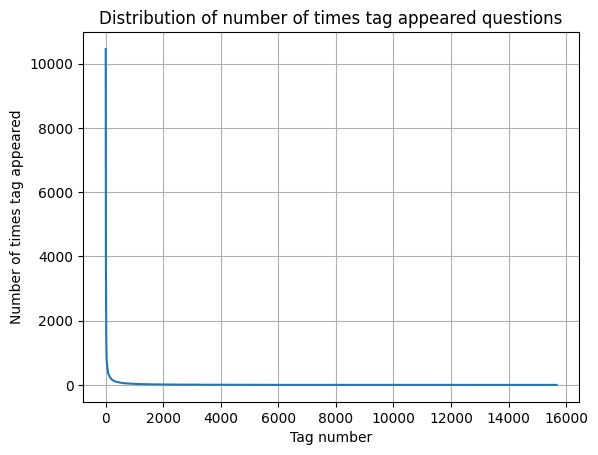

In [18]:
plt.plot(tag_counts['counts'])
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

**Observation:**
* Data is skewed and has long tail where few tag appear the most then the rest. 

Let's zoom it.

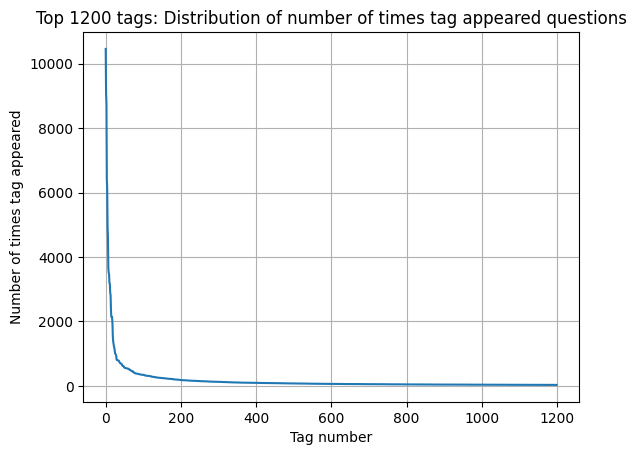

In [19]:
n = 1200
plt.plot(tag_counts[:n]['counts'])
plt.title(f"Top {n} tags: Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

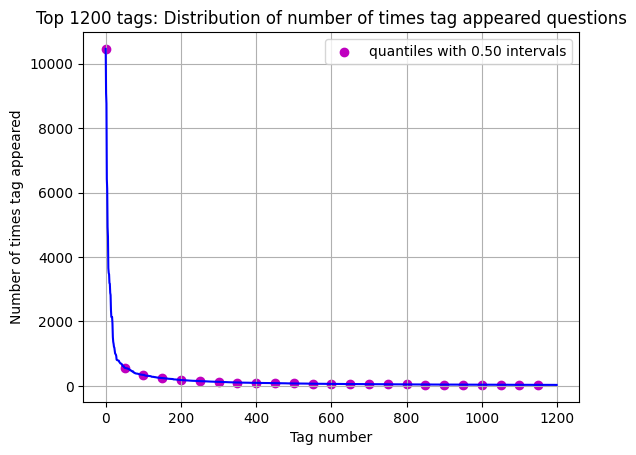

In [20]:
n = 1200
plt.plot(tag_counts[0:n]['counts'], c='b')

# quantiles with 0.25 difference
plt.scatter(x = list(range(0, n, 50)), y = tag_counts[0:n:50]['counts'], c = 'm', label = "quantiles with 0.50 intervals")

#for x,y in zip(list(range(0,100,50)), tag_counts[0:100:50]):
#    plt.annotate(text="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+0.05))

plt.title(f'Top {n} tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()

**Observation:**
* Number of points from 50 onwards are closer to each other. Implies top 50 tags occure most frequently.

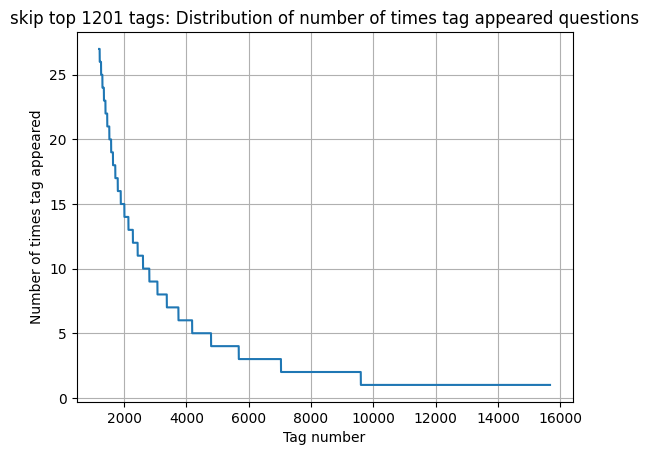

In [21]:
#Distribution from bottom
n = 1201
plt.plot(tag_counts[n:]['counts'])
plt.title(f"skip top {n} tags: Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

**Observation:**
1. Bottom tags form step distribution. Where most of the tags have same frequency.

#### 1.5.3 Most Frequent Tags ####

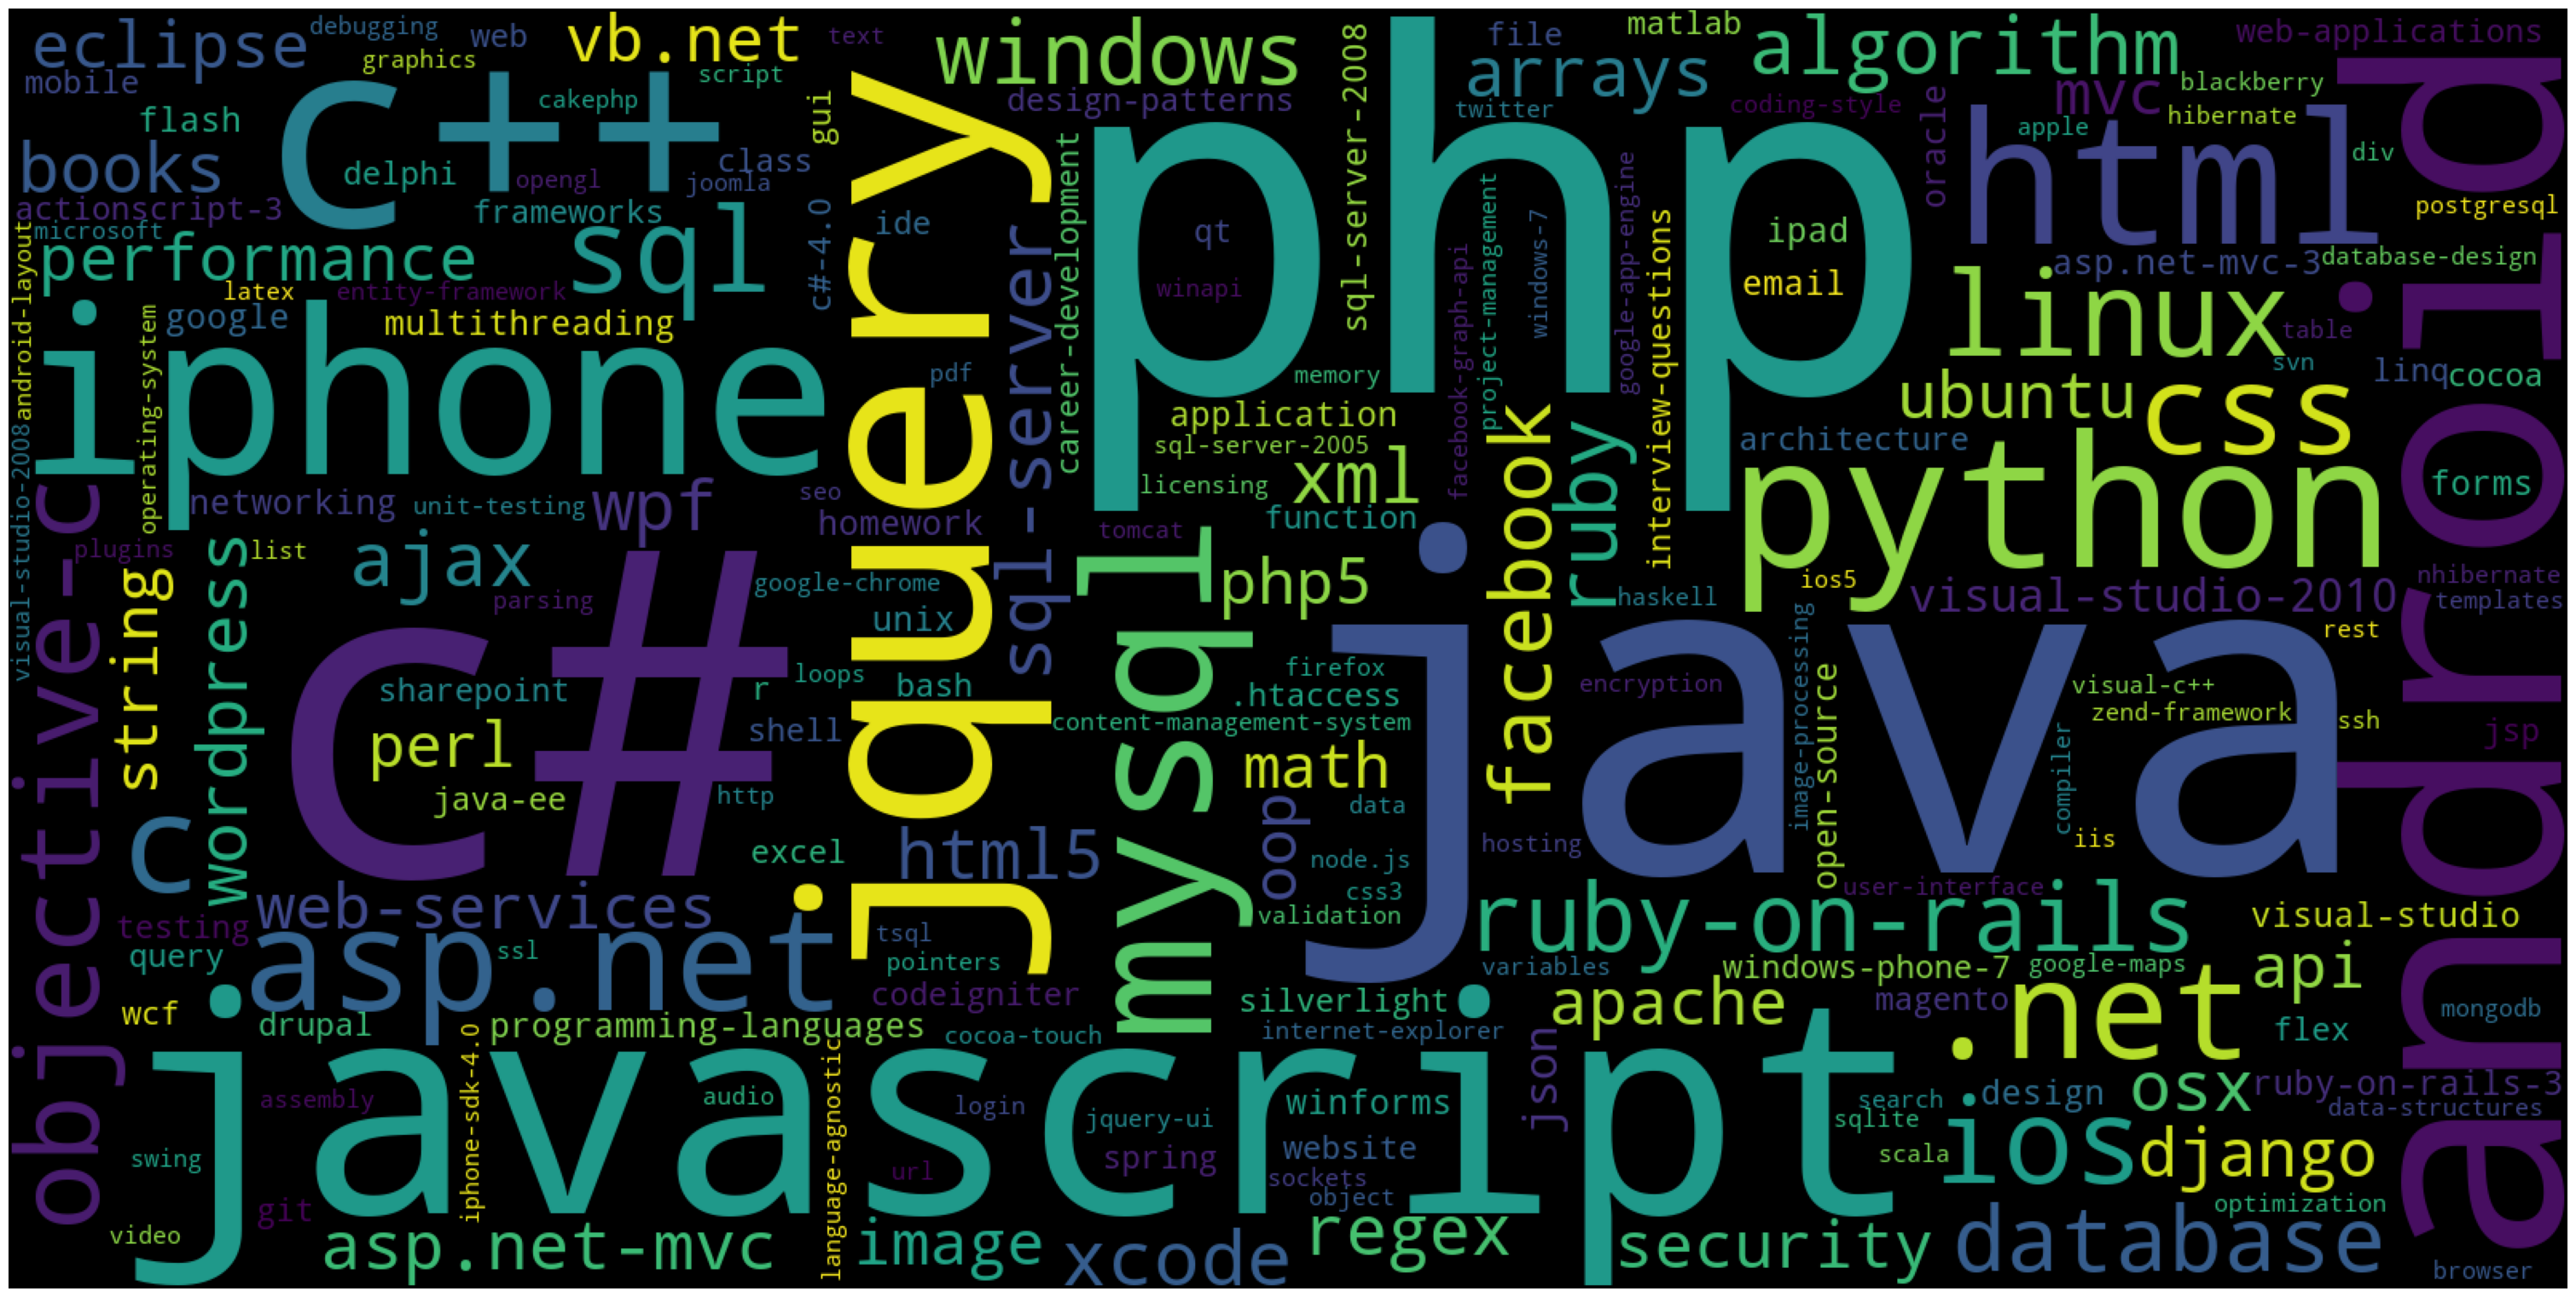

In [22]:
wordcloud = WordCloud(
                        background_color='black',
                        width=1600,
                        height=800,
                    ).generate_from_frequencies(tag_counts.set_index('tags').to_dict()['counts'])

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

**Observation:**
1. Top tags are java, php, python, c#, asp.net, javascript. 
2. Majority of the most frequent tags are programming language.
3. Android and windows are among the top most frequent operating systems.
4. Tags contain special char '-'.

#### 1.5.4 Number of question asked for least occuring tags ####

In [23]:
#Number of least occuring tags
feq = 1200
least_feq_tags = list(tag_counts[feq:].tags)
len(least_feq_tags)

14473

In [24]:
def contain_least_feq_tag(tags):

    num_least_feq_tags = 0
    feq_tags = False

    for tag in least_feq_tags:
        
        for tg in tags.split(','):

            if tag == tg:

                feq_tags = True
                num_least_feq_tags += 1

    return [feq_tags, num_least_feq_tags] 

In [25]:
df[['contains_feq_tags', 'num_least_feq_tags']]  = pd.DataFrame(list(df.tags.apply(contain_least_feq_tag)))
df[['contains_feq_tags', 'num_least_feq_tags']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103136 entries, 0 to 103135
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype
---  ------              --------------   -----
 0   contains_feq_tags   103136 non-null  bool 
 1   num_least_feq_tags  103136 non-null  int64
dtypes: bool(1), int64(1)
memory usage: 906.6 KB


In [26]:
df[['contains_feq_tags', 'num_least_feq_tags']].head()

,contains_feq_tags,num_least_feq_tags
0,False,0
1,True,2
2,False,0
3,True,3
4,True,1


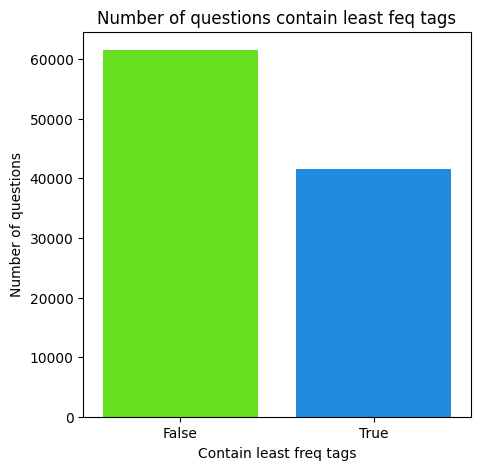

In [27]:
plt.figure(figsize = (5,5))
sns.countplot(data = df, x = 'contains_feq_tags', palette = 'gist_rainbow')
plt.title("Number of questions contain least feq tags")
plt.xlabel("Contain least freq tags")
plt.ylabel("Number of questions")
plt.show()

In [28]:
val_cnt = df.contains_feq_tags.value_counts()
print(f'Number of question contain least freq tags:',val_cnt[True])
print(f'% of question containing least freq tags:',((val_cnt[True]/df.shape[0])*100))

Number of question contain least freq tags: 41604
% of question containing least freq tags: 40.33896990381632


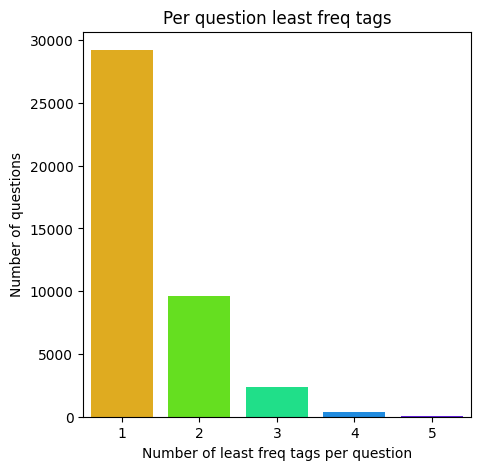

In [29]:
plt.figure(figsize = (5,5))
sns.countplot(data = df[df.contains_feq_tags == True], x = 'num_least_feq_tags', palette = 'gist_rainbow')
plt.title("Per question least freq tags")
plt.xlabel("Number of least freq tags per question")
plt.ylabel("Number of questions")
plt.show()

In [30]:
val_cnt = df[df.contains_feq_tags == True].num_least_feq_tags.value_counts()

print(f'% of question containing 1 of least freq tags:',((val_cnt[1]/val_cnt.sum())*100))
print(f'% of question containing 2 of least freq tags:',((val_cnt[2]/val_cnt.sum())*100))
print(f'% of question containing 3 of least freq tags:',((val_cnt[3]/val_cnt.sum())*100))
print(f'% of question containing 4 of least freq tags:',((val_cnt[4]/val_cnt.sum())*100))
print(f'% of question containing 5 of least freq tags:',((val_cnt[5]/val_cnt.sum())*100))

% of question containing 1 of least freq tags: 70.22642053648688
% of question containing 2 of least freq tags: 23.096336890683588
% of question containing 3 of least freq tags: 5.646091721949813
% of question containing 4 of least freq tags: 0.9422170945101431
% of question containing 5 of least freq tags: 0.08893375636957986


**Observation:**
1. Question contain at least 1 less freq used tags: 25337, Percentage: 40.33% 
2. Of 40.33%, percentage of question containing n of least freq tags:
    * 1: 70.22%  
    * 2: 23.09%
    * 3: 5.64%
    * 4: 0.94%
    * 5: 0.09%


#### 1.5.5 Tags Per Question ####

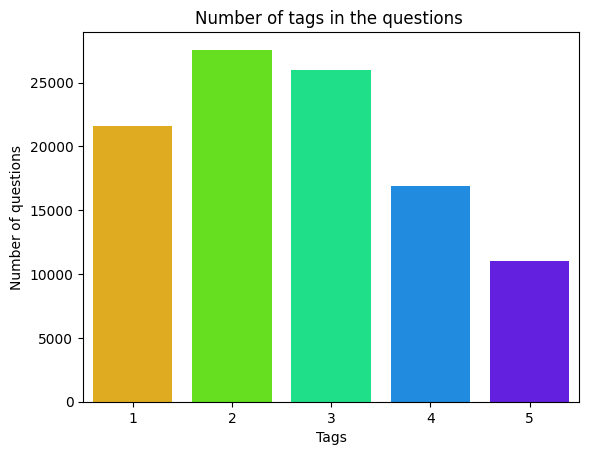

In [31]:
sns.countplot(data = df, x = 'tags_cnt', palette = 'gist_rainbow')
plt.title("Number of tags in the questions ")
plt.xlabel("Tags")
plt.ylabel("Number of questions")
plt.show()

**Observation:**
* Average tags per question: 2 to 3

#### 1.5.6 Least Freq Tags used in Question ####

In [32]:
# Check for question with least freq, if all the tags of the question are least occuring tags. 
# In that case the question itself is rare question 
temp_df = df[(df.contains_feq_tags == True) & (df.tags_cnt == df.num_least_feq_tags)]
print(f'Number of question where all the tags of question does not occure much: {temp_df.shape[0]}, %: {(temp_df.shape[0]/df.shape[0])}')

Number of question where all the tags of question does not occure much: 4055, %: 0.039317018305926155


In [33]:
temp_df.head()

,title,body,tags,tags_cnt,contains_feq_tags,num_least_feq_tags
8,What's the best USB switcher? (want to share ...,"\r\nI have a wireless keyboard, mouse, and a m...","kvm,switchers,synergy",3,True,3
22,A combinatorics question,In how many different ways can a cube be paint...,combinatorics,1,True,1
60,nexus s pc mount and ics 4.0.3 recovery black ...,"When i was using gingerbread 2.3.4, my nexus s...","usb-drive,nexus-s,error-recovery",3,True,3
113,Data Integration,I have been looking at data integration method...,data-integration,1,True,1
118,Intellisense good or evil,Is intellisesnse provided in most of the IDE's...,intellisense,1,True,1


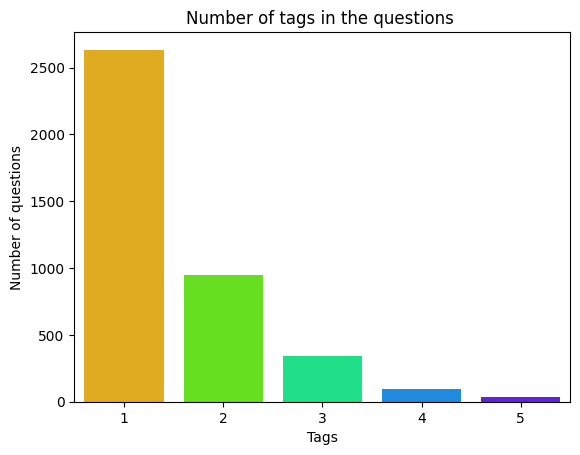

In [34]:
#Let's look at the tag distribution of those records
sns.countplot(data = temp_df, x = 'tags_cnt', palette = 'gist_rainbow')
plt.title("Number of tags in the questions")
plt.xlabel("Tags")
plt.ylabel("Number of questions")
plt.show()

**Observation:**

Records where all the tags of question belong to least occuring:

 1. Number of such records 4055, which is 0.039% of the entire dataset.
 2. Based on the plot most of those records question had only 1 tag. 

Drop records where occurance of all tags are least.
 

In [35]:
#Drop records where all tags belong to least.
df.drop(axis = 0, inplace = True, index = temp_df.index)
df.shape

(99081, 6)

In [36]:
#Question with only 1 most frequently used tags. i.e question like index 1 with total of 3 tags outofwhich 2 tags belong to least occuring tags
df[(df.contains_feq_tags == True) & ((df.tags_cnt-1) == df.num_least_feq_tags)]

,title,body,tags,tags_cnt,contains_feq_tags,num_least_feq_tags
1,Who doesn't trust a language whose sytax doesn...,A GENERAL question to programmers about how th...,"ruby,semicolon,terminate",3,True,2
12,synchronized in java Thread,my program is a client connect to multi server...,"java,thread",2,True,1
13,How to make app retrive information from a web...,I am developing an app that needs to retrieve ...,"android,app",2,True,1
27,any body knows if there any real biometrics a...,any body knows if there any real biometrics ap...,"android,biometrics",2,True,1
33,Ampersand in link description text?,I am validating my site using validator.w3.org...,"php,urlencode",2,True,1
...,...,...,...,...,...,...
103091,How to upgrade Apache from 2.2.3 to 2.2.21,Using **YUM** I installed apache. \r\nInstalle...,"apache,yum",2,True,1
103110,Codeigniter not working on one server but work...,"I developed the site in codeigniter, its worki...","codeigniter,working",2,True,1
103124,Superuser not prompting,I recently installed ICS(Android 4) on my Sams...,"android,galaxy,superuser",3,True,2
103130,Add $(this).find to prependTo,"I have this sentence:\r\n\r\n $(""<%= escape...","jquery,this,prepend",3,True,2


#### 1.5.7 Select number of unique tags that explain certain percentage of question ####

Reducing the problem to the most common tags in the dataset. Because for rare tags there are simply not enough samples available to get reliable results.

In [12]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(','), binary = True)
multilabel_y = vectorizer.fit_transform(df['tags'])

f:\github_workspace\stackoverflow_tag_question\.env\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [13]:
total_tags = multilabel_y.shape[1]
total_qs = df.shape[0]

print(f'Total Question: {total_qs}, total unique tags: {total_tags}')

Total Question: 99081, total unique tags: 14878


In [14]:
def tags_to_choose(n):

    t = multilabel_y.sum(axis = 0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key = lambda i: t[i], reverse = True) #retrun index of the max count. Refer: https://docs.python.org/3/howto/sorting.html
    
    multilabel_yn = multilabel_y[:,sorted_tags_i[:n]] #retun all rows with column index based on top n sorted tag index

    return multilabel_yn

def questions_explained_fn(n):

    multilabel_yn = tags_to_choose(n)
    x = multilabel_yn.sum(axis = 1) 
    return (np.count_nonzero(x==0)) #Sum the question with 0 tags are consider top n tags

In [15]:
#questions_explained = []
questions_explained = {}

for i in range(50, total_tags, 5): #experimented with different startindex and increment 
    exp = np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3)
    questions_explained[i] = exp
    #questions_explained.append()

In [16]:
print(f'Number of tags and question explaination pair: {len(questions_explained)}')

Number of tags and question explaination pair: 2966


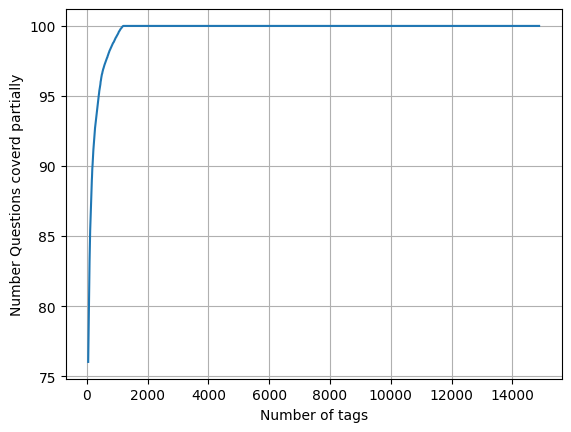

In [17]:
x =  questions_explained.keys()
y = questions_explained.values()
plt.plot(x, y)

plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()

In [18]:
for i in range(100, 1000, 5):
    print("of ",total_tags,"tags selected ",i,"tags which is covering ",questions_explained[i],"% of questions")

of  14878 tags selected  100 tags which is covering  83.827 % of questions
of  14878 tags selected  105 tags which is covering  84.335 % of questions
of  14878 tags selected  110 tags which is covering  85.027 % of questions
of  14878 tags selected  115 tags which is covering  85.386 % of questions
of  14878 tags selected  120 tags which is covering  85.734 % of questions
of  14878 tags selected  125 tags which is covering  86.244 % of questions
of  14878 tags selected  130 tags which is covering  86.526 % of questions
of  14878 tags selected  135 tags which is covering  86.966 % of questions
of  14878 tags selected  140 tags which is covering  87.19 % of questions
of  14878 tags selected  145 tags which is covering  87.451 % of questions
of  14878 tags selected  150 tags which is covering  87.76 % of questions
of  14878 tags selected  155 tags which is covering  88.093 % of questions
of  14878 tags selected  160 tags which is covering  88.449 % of questions
of  14878 tags selected  16

of  14878 tags selected  950 tags which is covering  99.14 % of questions
number of questions that are not covered : 852 out of  99081


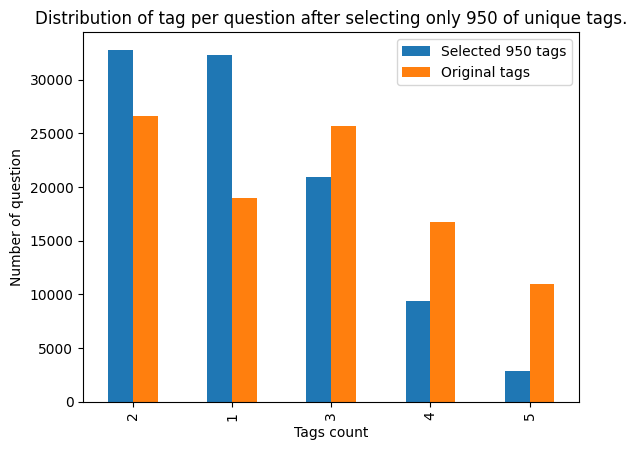

In [19]:
n = 950
print("of ",total_tags,"tags selected ",n,"tags which is covering ",questions_explained[n],"% of questions")

multilabel_yx = tags_to_choose(n)
print("number of questions that are not covered :", questions_explained_fn(n),"out of ", total_qs)

selected_tags_cnt = multilabel_yx.sum(axis = 1).A1
df['selected_tags_cnt'] = selected_tags_cnt


val_selected_tags_cnt = df['selected_tags_cnt'].value_counts().reset_index()
val_selected_tags_cnt.rename(columns = {'selected_tags_cnt': 'tags_cnt', 'count': 'selected'}, inplace = True)

val_tags_cnt = df['tags_cnt'].value_counts().reset_index()
val_tags_cnt.rename(columns = {'tags_cnt': 'tags_cnt', 'count': 'org'}, inplace = True)
tags_cnt = val_selected_tags_cnt.merge(val_tags_cnt, on = 'tags_cnt', how = 'inner')

tags_cnt.plot.bar(x = 'tags_cnt')
plt.legend([f"Selected {n} tags", "Original tags"])
plt.title(f'Distribution of tag per question after selecting only {n} of unique tags.')
plt.xlabel('Tags count')
plt.ylabel('Number of question')
plt.show()

of  14878 tags selected  200 tags which is covering  90.36 % of questions
number of questions that are not covered : 9551 out of  99081


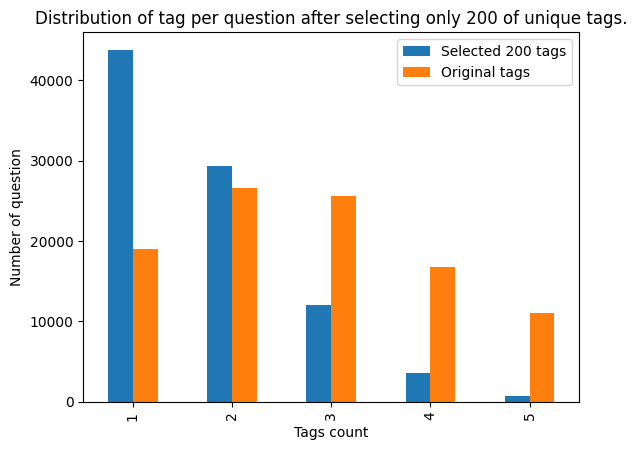

In [24]:
n = 200
print("of ",total_tags,"tags selected ",n,"tags which is covering ",questions_explained[n],"% of questions")

multilabel_yx = tags_to_choose(n)
print("number of questions that are not covered :", questions_explained_fn(n),"out of ", total_qs)

selected_tags_cnt = multilabel_yx.sum(axis = 1).A1
df['selected_tags_cnt'] = selected_tags_cnt

val_selected_tags_cnt = df['selected_tags_cnt'].value_counts().reset_index()
val_selected_tags_cnt.rename(columns = {'selected_tags_cnt': 'tags_cnt', 'count': 'selected'}, inplace = True)

val_tags_cnt = df['tags_cnt'].value_counts().reset_index()
val_tags_cnt.rename(columns = {'tags_cnt': 'tags_cnt', 'count': 'org'}, inplace = True)
tags_cnt = val_selected_tags_cnt.merge(val_tags_cnt, on = 'tags_cnt', how = 'inner')

tags_cnt.plot.bar(x = 'tags_cnt')
plt.legend([f"Selected {n} tags", "Original tags"])
plt.title(f'Distribution of tag per question after selecting only {n} of unique tags.')
plt.xlabel('Tags count')
plt.ylabel('Number of question')
plt.show()

**Observation:**
1. Number of question with 3,4,5 has reduce to 1,2. We can say that question that had 3-5 tags has reduce to now 1-2 tags per question.
2. With selected 950 tags average tags per question change from 2-3 to 1-2
3. By selected 200 tags we are reducing number of prediction of tags to 1 i.e 1 tag per question.

In [31]:
n = 200
t = multilabel_y.sum(axis = 0).tolist()[0]
sorted_tags_i = sorted(range(len(t)), key = lambda i: t[i], reverse = True)
selected_features = vectorizer.get_feature_names_out()[sorted_tags_i[:n]]
selected_features

array(['php', 'java', 'c#', 'javascript', 'android', 'c++', 'jquery',
       'iphone', 'python', 'html', 'mysql', 'asp.net', '.net', 'c', 'css',
       'sql', 'ios', 'linux', 'objective-c', 'ruby-on-rails', 'database',
       'windows', 'facebook', 'ruby', 'algorithm', 'ajax', 'sql-server',
       'xcode', 'xml', 'wordpress', 'books', 'regex', 'html5', 'arrays',
       'wpf', 'osx', 'asp.net-mvc', 'django', 'performance', 'ubuntu',
       'apache', 'eclipse', 'security', 'vb.net', 'image', 'string',
       'web-services', 'api', 'php5', 'perl', 'oop', 'math', 'mvc',
       'visual-studio-2010', 'json', 'programming-languages',
       'application', 'google', 'ipad', 'visual-studio', 'networking',
       'asp.net-mvc-3', 'design', 'multithreading', 'ruby-on-rails-3',
       'homework', 'flash', 'sql-server-2008', 'email', 'oracle', 'unix',
       'open-source', 'winforms', 'forms', 'frameworks', 'bash', 'file',
       'git', 'silverlight', 'linq', 'web-applications', 'website', 'web',
 

In [45]:
row_idx = np.nonzero(multilabel_y[:,sorted_tags_i[:n]].sum(axis = 1))[0] #Question with nonzero tags
X = df.iloc[row_idx,:]
X.shape

(89530, 10)

In [46]:
X.head(2)

,title,body,tags,tags_cnt,contains_feq_tags,num_least_feq_tags,len_title,clean_title,clean_title_len,selected_tags_cnt
index,,,,,,,,,,
0,good book recomendation for c++0x?,good book recomendation for c++0x?,"c++0x,books",2,False,0,34,good book recomend c0x,22,1
1,Who doesn't trust a language whose sytax doesn...,A GENERAL question to programmers about how th...,"ruby,semicolon,terminate",3,True,2,76,trust languag whose sytax termin semicolon,42,1


In [ ]:
#Rare labels by counting occurance of those lables 

### 1.6 Analysize text data ###

#### 1.6.1 Length of the text ####

In [2]:
df['len_title'] = df.title.apply(len)

In [3]:
df['len_title'].describe()

count    99081.000000
mean        47.413742
std         20.389139
min         10.000000
25%         33.000000
50%         44.000000
75%         58.000000
max        250.000000
Name: len_title, dtype: float64

In [40]:
np.quantile(df['len_title'], [0.75, 0.8, 0.9, 0.95, 0.96, 0.98])

array([ 58.,  63.,  75.,  86.,  89., 100.])

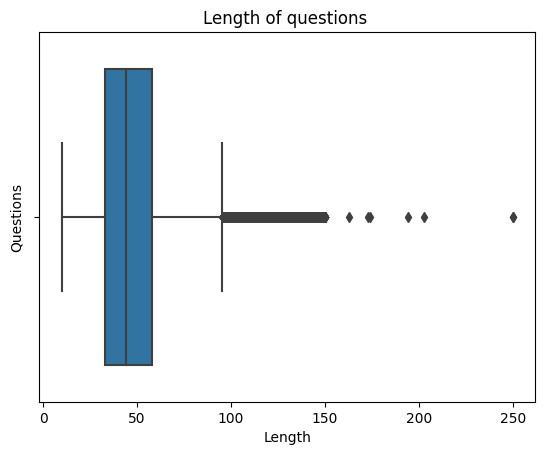

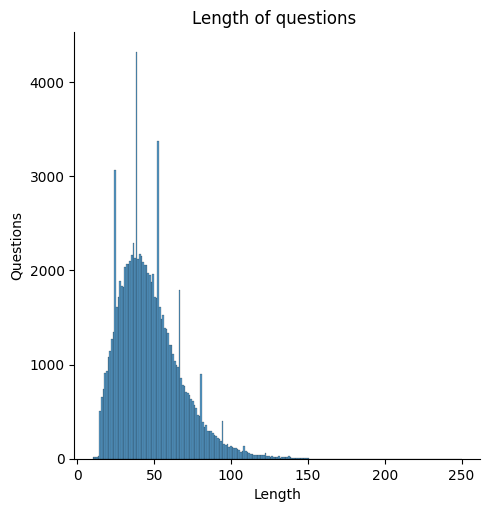

In [31]:
sns.boxplot(data = df, x = 'len_title')
plt.title("Length of questions ")
plt.xlabel("Length")
plt.ylabel("Questions")

sns.displot(data = df, x = 'len_title')
plt.title("Length of questions ")
plt.xlabel("Length")
plt.ylabel("Questions")
plt.show()

**Observation:**

1. Max and Min len of the title are 250 and 10 respectively. 
2. 75% of title length are bellow 58.
3. 98% of title length are bellow 100.

#### 1.6.2 CountVector for words in the Vocabulary ####

In [11]:
word_count = Counter(" ".join(df["title"]).split())
word_count

Counter({'to': 30188,
         'in': 22723,
         'a': 19618,
         'the': 13264,
         'How': 12839,
         'for': 11094,
         'and': 9872,
         'of': 9645,
         'with': 8291,
         'on': 7465,
         'is': 7127,
         'from': 5903,
         'I': 5666,
         'using': 4641,
         '-': 4190,
         'how': 4187,
         'What': 4098,
         'an': 4047,
         'not': 3893,
         'or': 3401,
         'do': 3253,
         'can': 3209,
         'my': 2848,
         'file': 2705,
         'Is': 2587,
         'PHP': 2556,
         'use': 2539,
         'it': 2421,
         'code': 2354,
         'when': 2200,
         'this': 2072,
         'data': 2016,
         'get': 1992,
         'Java': 1980,
         'that': 1933,
         'C#': 1898,
         'are': 1820,
         'Android': 1761,
         'i': 1750,
         'Why': 1741,
         'application': 1689,
         'web': 1667,
         'php': 1661,
         'you': 1556,
         'there': 1556

**Observation:**

-> Is there any relationship between the label and the words in the title that describe the question for least frequency number.

### 1.7 Preprocessing text data ###

In [40]:
print(df.body.sample(n = 50, random_state = 45 ).values)

['Can a section header in an instance of UITableView be made to intercept a touch?'
 'recently I am reading about Thinking in Java.\r\nthat code in my PC is not working,even I set up class path.\r\n\r\n"import static net.mindview.util.*;"\r\nI need some help.\r\n\r\n\r\n\r\n    package iteration;\r\n    import  static net.mindviwe.util.*;\r\n    public class Exercise1 {\r\n\tpublic static void main(String[] args) {\r\n\t\tfor(int i=0;i<=100;i++){\r\n\t\t\tSystem.out.println(i);\r\n\t\t}\r\n\t\tint i=0;\r\n\t\twhile(i<=100){\r\n\t\t\tprint(i+"  ");\r\n\t\t\ti++;\r\n\t\t}\r\n\r\n\t}\r\n\r\n}\r\n'
 'is there any api for image morphing in iphone os'
 'I am new to solr. I downloaded the latest solr 3.4.0 set the solr home to exampleDIH \r\n\r\n1. In the solr/db i changed the data-config.xml to my specific result sets.and did dataimort\r\n2. In the solr/tika did add some documents from databse and configured tika-config.xml and did dataimport\r\n\r\nI have an arraylist in java which uses sol

**Observation:**

1. Contain html tag, url and code in body. As body is where user enter most of the detail of the question that would ask.

In [41]:
print(df.title.sample(n = 50, random_state = 45 ).values)

['UITableView and touching section headers'
 'Thinking in Java jar package search'
 'how can i achieve image morphing in iphone os ?'
 'apache solr combining result set of tika and db and rss'
 'Preventing navigation via clicking anchor link in Actionscript'
 'Creating a JAVA POJO runtime during a method'
 'Is there a script to delete a message from a facebook conversation, without deleting the whole conversation?'
 'Unpacking zip file in c# using System.IO.Packaging'
 'How should I name my category with web-design works?'
 'cx_Oracle.so: undefined symbol:PyUnicodeUCS2_AsEncodedString'
 'Recommendation Engine development'
 'Why or why not should we use Java 7?'
 'Extjs4 GridPanel data is not loading'
 'Why do nearly all php-related e-commerce websites use object-oriented programming as a basic foundation?'
 'cocos2d scene as a bundle' 'Free host for ASP.NET C# project'
 'Want to make location app within building'
 'How to handle query string in PHP?' 'from jquery to page variables'
 'U

#### 1.6.1 Clean title ####

<ol> 
    <li> Remove Special characters from Question title (Except C#) </li>
    <li> Remove stop words </li>
    <li> Remove HTML Tags </li>
    <li> Remove numeric i.e keep only alphabet </li>
    <li> Convert all the characters into small letters </li>
    <li> Use SnowballStemmer to stem the words </li>    
</ol>

In [3]:
def striphtml(data):

    # Since all html tag start with '<' and end with '>'. 
    # So using regexpression we find any thing in the text that maths the pattern and replace with blank.

    cleanr = re.compile('<.*?>') 
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext

def decontracted(phrase):

    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    return phrase

def clean_title(text):
    
    #remove html
    text = striphtml(text)   

    #convert to_lower
    text = text.lower()

    #decontracted of text
    text = decontracted(text)

    #remove special char
    #special_char = string.punctuation
    #special_char = special_char.replace('#','')
    special_char = '[!"$%&\'()*+,-./:;<=>?@[\\]^_`{|}~"]'
    text = re.sub(special_char, '', text)

    #remove numberic
    text = re.sub("[^a-zA-Z]", " ", text)

    #removing all single letter and stopwords from question
    words = word_tokenize(text)
    text = ' '.join(str(ps.stem(j)) for j in words if j not in stop_words and len(j)!=1)    
    
    return text

#Init stop_words. Check if 'C' is a part of stopword. It was not.
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

#Init Stemmer. We can use other library for stemmer.
nltk.download("punkt")
ps = PorterStemmer()

#Clean title text
df['clean_title'] = df.title.apply(clean_title)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\smithau8\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\smithau8\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
df['clean_title_len'] = df.clean_title.apply(len)
df['clean_title_len'].describe()

count    99081.000000
mean        31.483705
std         13.182501
min          0.000000
25%         22.000000
50%         29.000000
75%         39.000000
max        163.000000
Name: clean_title_len, dtype: float64

In [5]:
np.quantile(df['clean_title_len'], [0.75, 0.8, 0.9, 0.95, 0.96, 0.98, 0.99, 1])

array([ 39.,  41.,  49.,  56.,  58.,  65.,  72., 163.])

Max lenght of clean title reduce to:  163


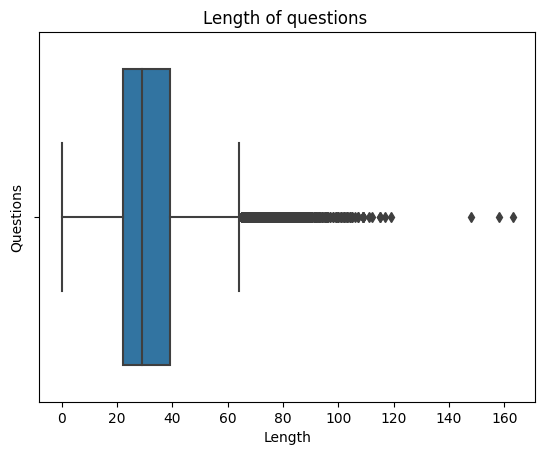

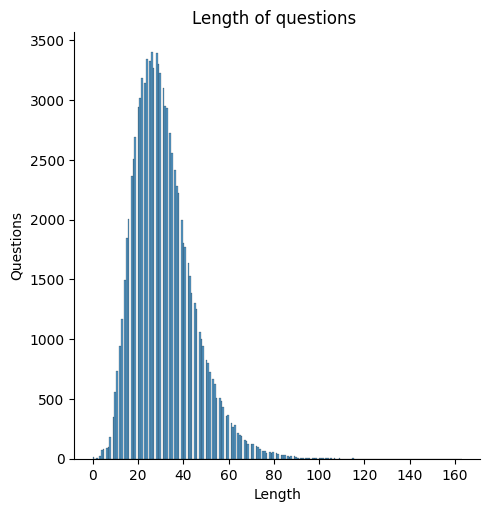

In [6]:
print('Max lenght of clean title reduce to: ', df['clean_title_len'].max())

sns.boxplot(data = df, x = 'clean_title_len')
plt.title("Length of questions ")
plt.xlabel("Length")
plt.ylabel("Questions")

sns.displot(df, x = "clean_title_len")
plt.title("Length of questions ")
plt.xlabel("Length")
plt.ylabel("Questions")
plt.show()

In [7]:
df[df['clean_title_len'] > 100].shape

(36, 10)

In [8]:
df[(df['clean_title_len'] > 80) & (df['clean_title_len'] < 100)].shape

(332, 10)

In [9]:
df[df['clean_title_len'] > 80].shape

(371, 10)

**Observation:**

1. After cleaning the title max length is reduce to 168.
2. 99% of clean title length is bellow 72.
3. There are 36 records where length is greater then 100.

For sequence padding shall consider max title length as 80

### Saving the file ### 

In [10]:
df.columns

Index(['title', 'body', 'tags', 'tags_cnt', 'contains_feq_tags',
       'num_least_feq_tags', 'len_title', 'clean_title', 'clean_title_len',
       'selected_tags_cnt'],
      dtype='object')

In [11]:
#Save to file
print(f'Size of the dataset:{df.shape[0]}')

save_path = Path(DATA_FOLDER).joinpath(jupiter_notebook_config.artifacts_dir).joinpath(jupiter_notebook_config.root_dir).joinpath(jupiter_notebook_config.cleaned_data_filename)
#os.path.join(DATA_FOLDER, 'processed', 'tags_text_processed.parquet')

df.to_parquet(save_path, engine = 'fastparquet')

Size of the dataset:99081


###  Why Sigmoid and not Softmax in the final dense layer? ###

Softmax function is a generalization of the logistic function that “squashes” a K-dimensional vector Z of arbitrary real values to a K-dimensional vector Z' of real values in the range [0,1] that add up to 1.
Sigmoid function transforms any real value to a number between 0 and 1.

In the final layer of the architecture, sigmoid function as been used instead of softmax. The advantage of using Sigmoid over Softmax lies in the fact that single datapoint/question may have many possible label/tags. 
Using the Softmax function would imply that the probability of occurrence of one tag depends on the occurrence of other tag. i.e if  probability of one tag is x then probability of other tag can be more/less then x, but sum of there probability should not exceed 1. So this make probability of tags to be dependent on one other.
So consequence of using the softmax function is that the probability for a class is not independent from the other class probabilities. This is nice as long as we only want to predict a single label per sample.

Since in our application, we need a function that would give scores for the occurrence of tag, which would be independent of occurrences of any other tags.
So sigmoid activation function at the output layer the neural network models the probability of a class is independent from the other class probabilities, since it transform each value in range of [0,1] independent of other value. 

Second problem with softmax is we are not clearly number of tags/class to pick based on the probability. If we know how many labels we want for a sample then we can sort the probability and consider top n as label. That is not the case. Where as with in case of sigmoid we can use the threshold and any tags/lable above the threshold is our predict class label/tags.

####  Why binary_crossentropy and not categorical_crossentropy as loss function? ####

We use the binary_crossentropy loss and not the usual in multi-class classification used categorical_crossentropy loss. Because we want to penalize each output node independently. So we pick a binary loss and model the output of the network as a independent Bernoulli distributions per label.

Help refer: https://www.depends-on-the-definition.com/guide-to-multi-label-classification-with-neural-networks/

#### Evaluate Metric ####

For binary classification problem we generally use F1Score, Precision and Recall. For multi-label classification problem we shall used micro average F1Score which is modifyed F1-Score.